# Read me

# Data retrieval

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels

1
/home/VM-Nicolas-Lafon/These/4Dvarnetstochastic/Danube_river_network


In [16]:
ncfile = Dataset('Results/test_Bestmodel1.nc')
print(ncfile)
mu = ncfile['preds']
prec = ncfile['p_diag']
init   = ncfile['inits']
target = ncfile['targets']
masks = ncfile['masks']


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Nb_samples(1749), time(31), x(48)
    variables(dimensions): float32 preds(Nb_samples, time, x), float32 p_diag(Nb_samples, time, x), float32 inits(Nb_samples, time, x), float32 targets(Nb_samples, time, x), float32 masks(Nb_samples, time, x), float64 Nb_samples(Nb_samples), float64 time(time), float64 space(x)
    groups: 


# Experiment 

![River network](Images/Danube.PNG)
<figcaption align = "center"><b>Gauging stations on river network, from $Asadi\ et\ al.\ (2015). $</b></figcaption>

We reconstruct the mean state and the diagonal covariance for all stations given available observations every 4 time steps for half of the stations, namely the stations number 3, 4, 8, 9, 11, 15, 16, 17, 20, 21, 22, 23, 24, 25, 30, 31. It implies that stations number 1, 2, 5, 6, 7, 10, 12, 13, 14, 18, 19, 26, 27, 28 and 29 are unobserved. Each time window is 48 time steps long.

## Visualization of the temporal evolution for the first three stations for a given time window

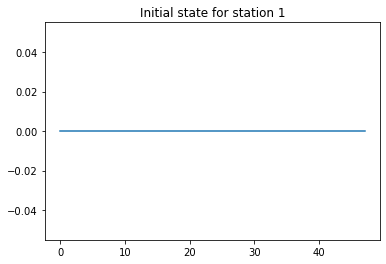

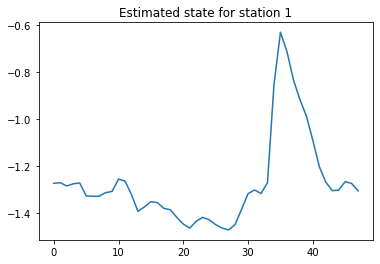

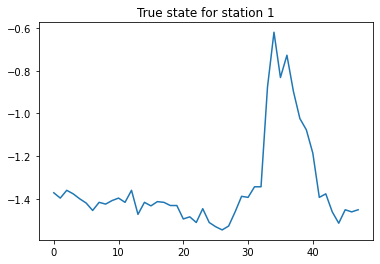

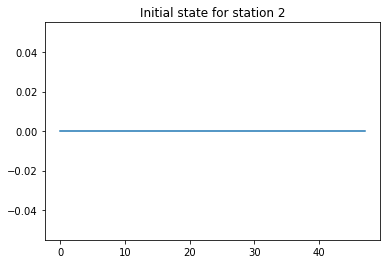

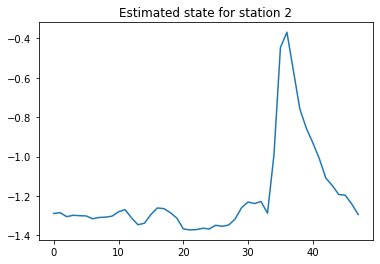

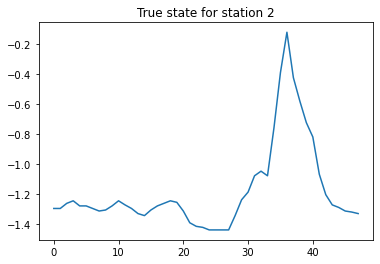

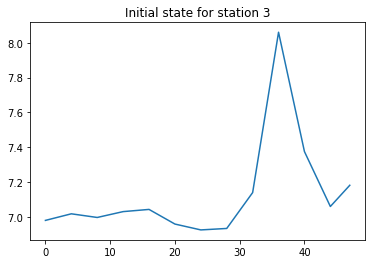

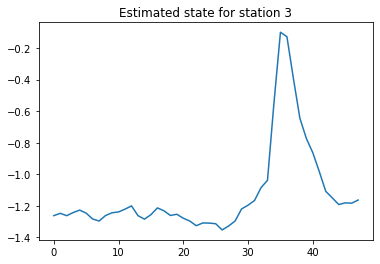

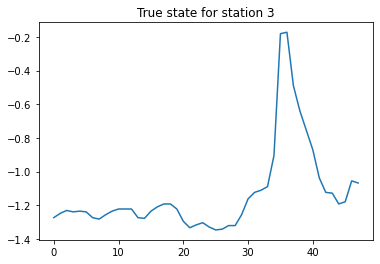

In [3]:
plt.figure()
plt.title('Initial state for station 1')
plt.plot(init[100,0,:])

plt.figure()
plt.title('Estimated state for station 1')
plt.plot(mu[100,0,:])

plt.figure()
plt.title('True state for station 1')
plt.plot(target[100,0,:])

plt.figure()
plt.title('Initial state for station 2')
plt.plot(init[100,1,:])

plt.figure()
plt.title('Estimated state for station 2')
plt.plot(mu[100,1,:])

plt.figure()
plt.title('True state for station 2')
plt.plot(target[100,1,:])

plt.figure()
plt.title('Initial state for station 3')
plt.plot(init[100,2,:])

plt.figure()
plt.title('Estimated state for station 3')
plt.plot(mu[100,2,:])

plt.figure()
plt.title('True state for station 3')
plt.plot(target[100,2,:])


## Visualization of the reconstructed state and the uncertainties vs real state

[]

<Figure size 432x288 with 0 Axes>

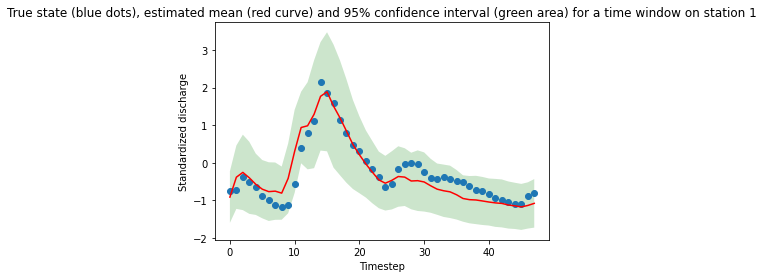

In [8]:
plt.figure()
cov =(1/p_diag[:,:,:])**2
station =0
t=950
#some example data
x = mu[t,station,:]
sig = cov[t,station,:]
#some confidence interval
ci = sig

fig, ax = plt.subplots()
ax.plot(range(48),x, color='r')
ax.fill_between(range(48), (x-ci), (x+ci), facecolor='g', alpha=0.2)
plt.scatter(np.arange(0,48),target[t,station,:])
plt.title("True state (blue dots), estimated mean (red curve) and 95% confidence interval (green area) for a time window on station 1")
plt.xlabel("Timestep")
plt.ylabel("Standardized discharge")
plt.plot()

## Learned dynamical model

In [27]:
from models import Gradient_img, LitModel
import torch
ckpt_path ='Results/Bestmodel1.ckpt'
lit_cls = LitModel
mod = lit_cls.load_from_checkpoint(ckpt_path, 
                                                    mean_Tr=0, 
                                                    std_Tr = 0
                                                    )

In [11]:
mu_test = torch.zeros((1749,62,48))
mu_test[:,:31,:] = torch.Tensor(mu[:,:,:])
target_test = torch.zeros((1749,62,48))
target_test[:,:31,:] = torch.Tensor(target[:,:,:])

dyn_mu = mod.model.phi_r(mu_test).detach().numpy()
dyn_target = mod.model.phi_r(target_test).detach().numpy()

/home/VM-Nicolas-Lafon/These/4Dvarnetstochastic/Danube_river_network/models.py:59: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554798336/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  x   = torch.add(x,1.,xHR)


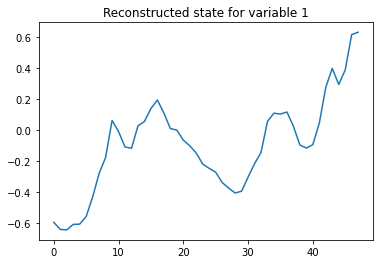

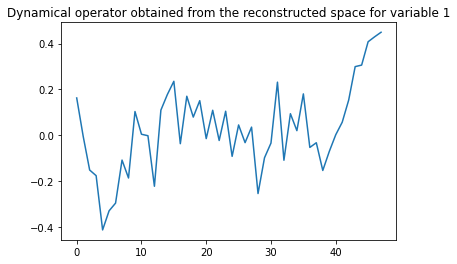

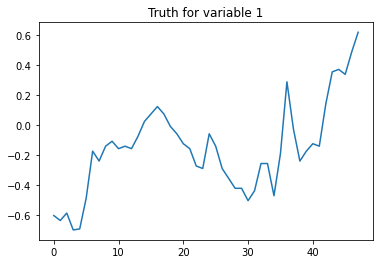

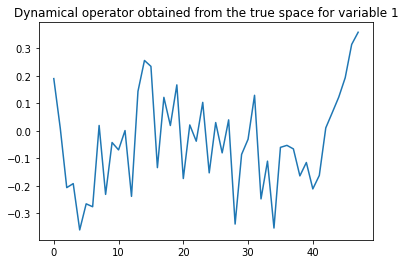

In [12]:
plt.figure()
plt.title("Reconstructed state for station 1")
plt.plot(mu[0,0,:])

plt.figure()
plt.title("Dynamical operator obtained from the reconstructed space for station 1")
plt.plot(dyn_mu[0,0,:])

plt.figure()
plt.title("Truth for station 1")
plt.plot(target[0,0,:])

plt.figure()
plt.title("Dynamical operator obtained from the true space for station 1")
plt.plot(dyn_target[0,0,:])


## Scores assessment

In [14]:
print("R-score")
print(np.mean((mu[:,:,:]-target[:,:,:])**2))
print("4DVar-score")
FourDScore = 0.01*np.mean((init[:,:,:]-mu[:,:,:])*masks[:,:,:])**2/(np.sum(masks[:,:,:])) + np.mean((mu[:,:,:]-dyn_mu[:,:31,:])**2)
print(FourDScore)
print("ODE-score")
print(np.mean((target[:,:,:]-dyn_target[:,:31,:])**2))

# Results for interpolated values
print("I-score")
print(np.sum(((mu[:,:,:]-target[:,:,:])*(1-masks[:,:,:]))**2)/np.sum(1-masks[:,:,:]))


R-score
0.1096438
4DVar-score
0.21726050482633139
ODE-score
0.23906504
I-score
0.12662809


## Visualization of temporal evolution for covariance


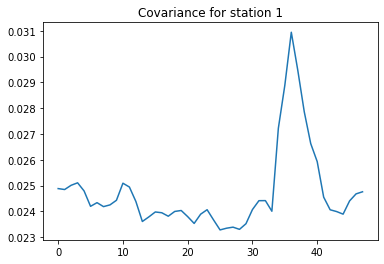

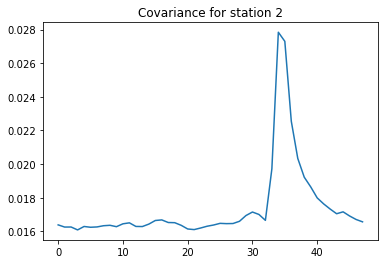

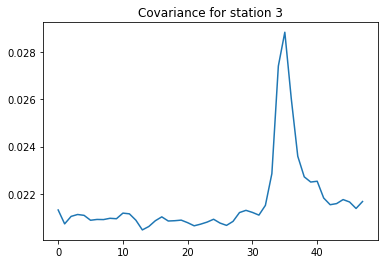

In [17]:

plt.figure()
plt.title('Covariance for station 1')
plt.plot(1/((prec[100,0,:])*5)**2)



plt.figure()
plt.title('Covariance for station 2')
plt.plot(1/(np.abs(prec[100,1,:])*5)**2)


plt.figure()
plt.title('Covariance for station 3')
plt.plot(1/(np.abs(prec[100,2,:])*5)**2)




In [18]:
#Likelihood score for probability distribution

def logarithmic_scores(t,mu,sig):
    return(0.5*(((t-mu)*sig*5)**2)-np.log(sig*5)+0.5*np.log(2*np.pi))

scores = np.mean(logarithmic_scores(target[:,:,:],mu[:,:,:],np.abs(prec[:,:,:])),0)

(31, 48)


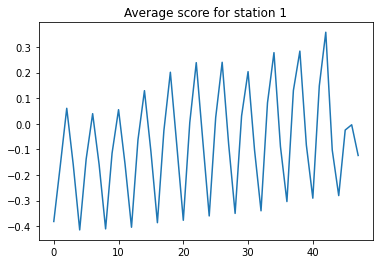

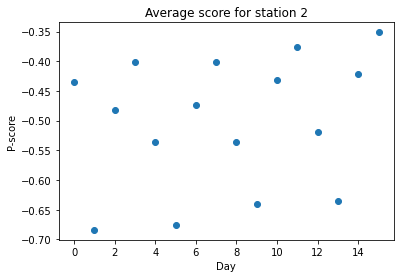

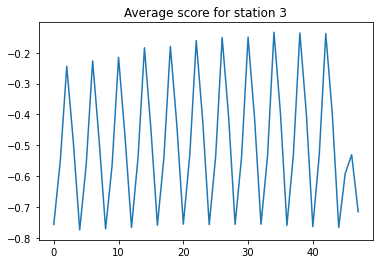

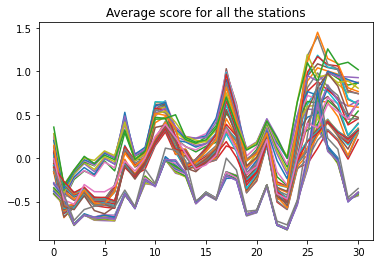

In [19]:
#Visualisation de l'évolution du p-score pour chaque variable :
print(scores.shape)
plt.figure()
plt.title("Average score for station 1")
plt.plot(scores[0,:])

plt.figure()
plt.title("Average score for station 2")
plt.scatter(range(16),scores[1,:16])
plt.xlabel('Day')
plt.ylabel('P-score')


plt.figure()
plt.title("Average score for station 3")
plt.plot(scores[2,:])

state_score = scores
plt.figure()
plt.title("Average score for all the stations")
plt.plot(state_score)


In [20]:
print("P-score")
print(np.mean(state_score))
print("P-score for the masked stations")
print(np.sum(state_score[:,:]*(1-masks[:,:,:]))/np.sum(1-masks[:,:,:]))

P-score
-0.017724231009546888
P-score for the masked stations
0.06684805147398822


## Comparison with naive p-score

In [26]:
# First set up 
# Covariance set to mean square discrepency between true state and estimated state (I-score)
N_cov = 0.1566
N_scores = np.mean(logarithmic_scores(target[:,:,:],mu[:,:,:],N_cov),0)
print("P-score for the first naive set up")
print(np.mean(np.sum(N_scores,0)))

# Second set up
# Covariance is taken equal to the mean square error per station
N_cov2 = np.mean((target[:,:,:]-mu[:,:,:])**2,0)
N_cov2 = N_cov2*(1-masks[0,:,:])
N_cov2 = np.sum(N_cov2,1)/np.sum((1-masks[0,:,:]),1)
N_cov2bis = np.zeros(target[:,:,:].shape)
for i in range(N_cov2bis.shape[0]):
    for j in range(N_cov2bis.shape[1]):
        N_cov2bis[i,:,j]=N_cov2

N_scores2 = np.mean(logarithmic_scores(target[:,:,:],mu[:,:,:],N_cov2bis),0)

N_scores2 = (np.sum(N_scores2*(1-masks[0,:,:]),1)/np.sum((1-masks[0,:,:]),1))
print("P-score for the second naive set up")
print(np.mean(N_scores2))

P-score for the first naive set up
37.11232
P-score for the second naive set up
1.0661552599900002


<ipython-input-18-a8b341f42694>:4: RuntimeWarning: divide by zero encountered in log
  return(0.5*(((t-mu)*sig*5)**2)-np.log(sig*5)+0.5*np.log(2*np.pi))
